In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

### Week 4: NLP with Disaster Tweets

#### Problem
This project will be looking at various Tweets from the social media platform Twitter/X, and building a Natural Language Processing Model to identify whether a tweet is indicating a disaster occurence or not. This project will use data from https://www.kaggle.com/c/nlp-getting-started/overview, using training data labeled with text, keywords, location, and whether or not it's a real disaster or not.

#### EDA
First starting out by importing the CSVs and taking a look at the training data. I'll import all columns as strings so I don't need to convert them later.

In [98]:
train_df = pd.read_csv('nlp-getting-started/train.csv')
test_df = pd.read_csv('nlp-getting-started/test.csv')
submit_df = pd.read_csv('nlp-getting-started/sample_submission.csv')

print(train_df.info())
print("Columns: ", train_df.columns)
print("Training data shape: ", train_df.shape)
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
Columns:  Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')
Training data shape:  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Looking at the data from train_df.info(), there's 7613 total entries with 5 columns in the data set, but 2533 of them are missing location data, and 61 of them are missing keywords. 

Looking at the test data, missing location/keyword data is a regular occurence, so I'll likely want to keep entries with missing info during training still, but I'll fill in the null values with the empty string '' so it doesn't cause issues later.

In [95]:
train_df.fillna('')
test_df.fillna('')
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


I also want to check the balance of the data to see if it's heavily skewed towards either label. Looking at the graph, there's about a 1000 more 0s than 1s, but it's not overly imbalanced, so I'll keep it as is.

target
0    4342
1    3271
Name: count, dtype: int64


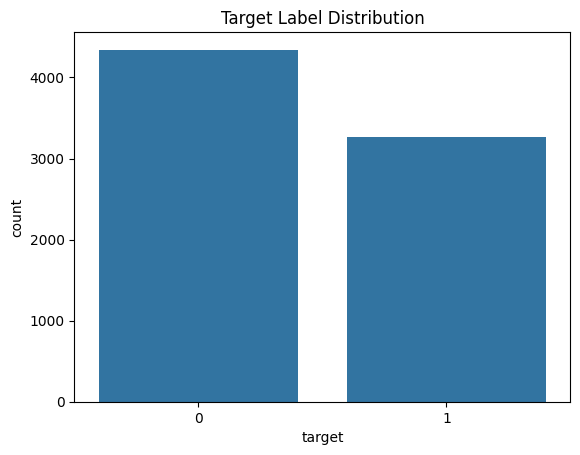

In [96]:
print(train_df['target'].value_counts())
sns.countplot(x='target', data=train_df)
plt.title('Target Label Distribution')
plt.show()

We need to preprocess the text a bit before feeding to the model. I'll be cleaning up the text column by removing punctuation, stop words, and tokenizing the text.

In [97]:
# Preprocessing text
import spacy

nlp = spacy.load("en_core_web_sm")

def text_preprocess(text):
    # Lower casing
    doc = nlp(text.lower())

    # Removing Punctuation, Stop words, and Tokenizing
    tokens = [token.lemma_ for token in doc if (not token.is_stop and not token.is_punct and not token.is_digit)] 

    return ' '.join(tokens)

# Do I actually want to remove stop words?
train_df['text'] = train_df['text'].apply(text_preprocess)
test_df['text'] = test_df['text'].apply(text_preprocess)

# train_df['keyword'] = train_df['keyword'].apply(text_preprocess)
# test_df['keyword'] = test_df['keyword'].apply(text_preprocess)

print("Clean text example: " + train_df['text'][0])

Clean text example: deed reason earthquake allah forgive


I want to get an idea of what the text looks like now, so I'll take a look at the text length and the number of unique words.

In [100]:
from collections import Counter

def count_words(text):
    count = Counter()
    for t in text.values:
        for word in t.split():
            count[word] += 1
    return count

unique_word_count = len(count_words(train_df.text))
print("Unique Word Count: ", unique_word_count)

text_length = train_df['text'].str.len()
text_length.describe()


Unique Word Count:  31924


count    7613.000000
mean      101.037436
std        33.781325
min         7.000000
25%        78.000000
50%       107.000000
75%       133.000000
max       157.000000
Name: text, dtype: float64

We also need to split the training data into training and validation sets. I'll split 0/1 individually so there's an even distribution of 0/1s in the test and validation set. Going to start with just using the text column for X (and target for y).

In [102]:
# Splitting sets
from sklearn.model_selection import train_test_split

zeros = train_df[train_df['target'] == 0]
ones = train_df[train_df['target'] == 1]

train0, val0 = train_test_split(zeros, test_size=0.3, random_state=10)
train1, val1 = train_test_split(ones, test_size=0.3, random_state=10)

train_set = pd.concat([train0, train1])
val_set = pd.concat([val0, val1])

X_train = np.array(train_set.text)
y_train = np.array(train_set.target)
X_valid = np.array(val_set.text)
y_valid = np.array(val_set.target)

print(X_train[0])

train_set.head()

#SBNation #Flames What Makes a Good Penalty Killer? http://t.co/xYi5fDacxO http://t.co/SjtvzgGcXU


,id,keyword,location,text,target
3846,5473,flames,NaN,#SBNation #Flames What Makes a Good Penalty Ki...,0
3136,4507,emergency,New York,Survival Kit Whistle Fire Starter Wire Saw Cre...,0
6186,8831,sirens,"Los Angles, CA",What's going on in Hollywood? #abc7eyewitness ...,0
1945,2796,curfew,NaN,When you're 5 hours late for curfew and have t...,0
1555,2245,chemical%20emergency,"Jersey City, NJ",@laevantine Fortunately I reworked the plumbin...,0


In [103]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words = unique_word_count)
tokenizer.fit_on_texts(X_train)

train_sequence = tokenizer.texts_to_sequences(X_train)
val_sequence = tokenizer.texts_to_sequences(X_valid)

print(X_train[1:3])
print(train_sequence[1:3])


# Max number of words in a sequence
MAX_LEN = 20

train_pad = pad_sequences(train_sequence, maxlen=MAX_LEN, padding="post", truncating="post")
val_pad = pad_sequences(val_sequence, maxlen=MAX_LEN, padding="post", truncating="post")

['Survival Kit Whistle Fire Starter Wire Saw Cree Torch Emergency Blanket S knife  - Full re\x89Û_ http://t.co/2OroYUNYM2 http://t.co/C9JnXz3DXC'
 "What's going on in Hollywood? #abc7eyewitness @ABC7 helicopters and sirens. #HometownGlory"]
[[1893, 1487, 3667, 42, 2741, 2231, 398, 1058, 2232, 78, 3668, 99, 3669, 119, 580, 3, 1, 2, 5526, 3, 1, 2, 5527], [612, 123, 13, 6, 644, 5528, 3670, 3671, 9, 775, 5529]]


#### Model Architecture

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. 

Since we did not learn NLP-specific techniques such as word embeddings in the lectures, we recommend looking at Kaggle tutorials, discussion boards, and code examples posted for this challenge.  You can use any resources needed, but make sure you “demonstrate” you understood by including explanations in your own words. Also importantly, please have a reference list at the end of the report.  

There are many methods to process texts to matrix form (word embedding), including TF-IDF, GloVe, Word2Vec, etc. Pick a strategy and process the raw texts to word embedding. Briefly explain the method(s) and how they work in your own words.

Build and train your sequential neural network model (You may use any RNN family neural network, including advanced architectures LSTM, GRU, bidirectional RNN, etc.). 

In [104]:
# Creating basic architecture
# EMBEDDING_DIM = 128

def basic_RNN():
    model = Sequential([
        Embedding(unique_word_count, 128), #, input_length=MAX_LEN  #deprecated?
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.5),
        Bidirectional(LSTM(32)),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

basic_model = basic_RNN()
basic_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_9 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_16                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_17                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Next we'll compile the model. I'll use the Adam optimizer since it'll handle some of the learning rate balancing, and I'll use binary cross-entropy for the loss function. I'll start the learning rate at 0.001 and adjust if it learns too fast/slow.

### Model 1

In [107]:
LEARN_RATE = 0.001

optimizer = Adam(LEARN_RATE)

basic_model.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

In [108]:
BATCH_SIZE = 64
EPOCHS = 20

history1 = basic_model.fit(train_pad, y_train, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                validation_data=(val_pad, y_valid))

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.9960 - loss: 0.0162 - val_accuracy: 0.7751 - val_loss: 1.3158
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.9874 - loss: 0.0256 - val_accuracy: 0.7698 - val_loss: 1.3510
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9918 - loss: 0.0165 - val_accuracy: 0.7593 - val_loss: 1.3790
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9942 - loss: 0.0092 - val_accuracy: 0.7580 - val_loss: 1.6594
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.9945 - loss: 0.0091 - val_accuracy: 0.7667 - val_loss: 1.5230
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9939 - loss: 0.0083 - val_accuracy: 0.7567 - val_loss: 1.8781
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9956 - loss: 0.0087 - val_accuracy: 0.7619 - val_loss: 1.8753
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9945 - loss: 0.0082 - val_accuracy: 0.7619 - v

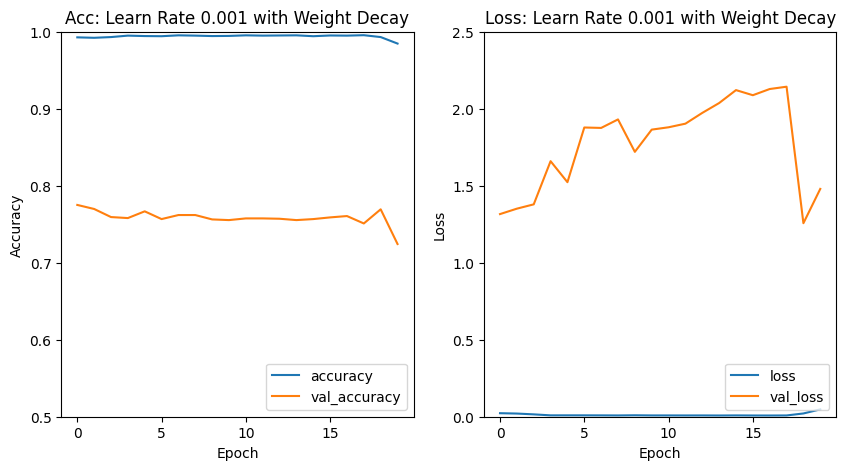

In [113]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history1.history['accuracy'], label='accuracy')
ax1.plot(history1.history['val_accuracy'], label = 'val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0.5, 1])
ax1.set_title('Acc: Learn Rate 0.001')
ax1.legend(loc='lower right')

ax2.plot(history1.history['loss'], label='loss')
ax2.plot(history1.history['val_loss'], label = 'val_loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_ylim([0, 2.5])
ax2.set_title('Loss: Learn Rate 0.001')
ax2.legend(loc='lower right')

#### Results and Analysis
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

#### Conclusion
Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

This first run didn't quite go like I expected. It seems like it immediately converged into something incorrect, given that accuracy for the validation set is pretty stable at around .76 (and even somewhat decreases) as more epochs gets added, while the training set accuracy is almost a 1. 

That likely means right from the start, the model is overfitting way too much, so I likely need to slow down the model/fitting. I'm going to try lowering the learning rate all the way to 0.0001, and increase the epoch count to see what results I get.

### Model 2

In [119]:
basic_model2 = basic_RNN()
LEARN_RATE = 0.0001

optimizer = Adam(LEARN_RATE)

basic_model2.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

BATCH_SIZE = 64
EPOCHS = 30

history2 = basic_model2.fit(train_pad, y_train, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                validation_data=(val_pad, y_valid))

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5441 - loss: 0.6896 - val_accuracy: 0.5702 - val_loss: 0.6691
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.5876 - loss: 0.6604 - val_accuracy: 0.7063 - val_loss: 0.6134
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.7732 - loss: 0.5576 - val_accuracy: 0.7982 - val_loss: 0.4572
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8714 - loss: 0.3480 - val_accuracy: 0.8057 - val_loss: 0.4520
Epoch 5/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9251 - loss: 0.2199 - val_accuracy: 0.7899 - val_loss: 0.5043
Epoch 6/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9538 - loss: 0.1414 - val_accuracy: 0.7921 - val_loss: 0.5901
Epoch 7/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9723 - loss: 0.0932 - val_accuracy: 0.7917 - val_loss: 0.6999
Epoch 8/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9798 - loss: 0.0656 - val_accuracy: 0.7733 - v

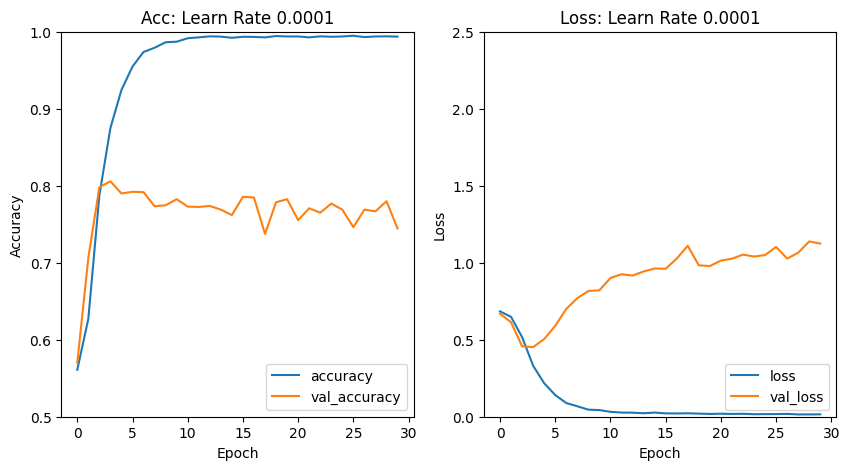

In [120]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history2.history['accuracy'], label='accuracy')
ax1.plot(history2.history['val_accuracy'], label = 'val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0.5, 1])
ax1.set_title('Acc: Learn Rate 0.0001')
ax1.legend(loc='lower right')

ax2.plot(history2.history['loss'], label='loss')
ax2.plot(history2.history['val_loss'], label = 'val_loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_ylim([0, 2.5])
ax2.set_title('Loss: Learn Rate 0.0001')
ax2.legend(loc='lower right')

Unfortunately, slowing down the learning rate to 0.0001 doesn't seem to be enough still. While it doesn't immediately converge like before, it still converges very quickly, and the shows signs of overfitting. I'll try one more time with tuning the learning rate, all the way to 0.00001 and increasing the epoch count to 50 to give it more time. 

### Model 3

In [121]:
basic_model3 = basic_RNN()
LEARN_RATE = 0.00001

optimizer = Adam(LEARN_RATE)

basic_model3.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

BATCH_SIZE = 64
EPOCHS = 50

history3 = basic_model3.fit(train_pad, y_train, 
                epochs=EPOCHS, 
                batch_size=BATCH_SIZE, 
                validation_data=(val_pad, y_valid))

Epoch 1/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.5361 - loss: 0.6922 - val_accuracy: 0.5746 - val_loss: 0.6903
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.5523 - loss: 0.6906 - val_accuracy: 0.5698 - val_loss: 0.6881
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5784 - loss: 0.6877 - val_accuracy: 0.5702 - val_loss: 0.6855
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.5781 - loss: 0.6862 - val_accuracy: 0.5702 - val_loss: 0.6827
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.5656 - loss: 0.6833 - val_accuracy: 0.5702 - val_loss: 0.6794
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5645 - loss: 0.6802 - val_accuracy: 0.5702 - val_loss: 0.6757
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5625 - loss: 0.6769 - val_accuracy: 0.5702 - val_loss: 0.6723
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - accuracy: 0.5800 - loss: 0.6718 - val_accuracy: 0.5702 - v

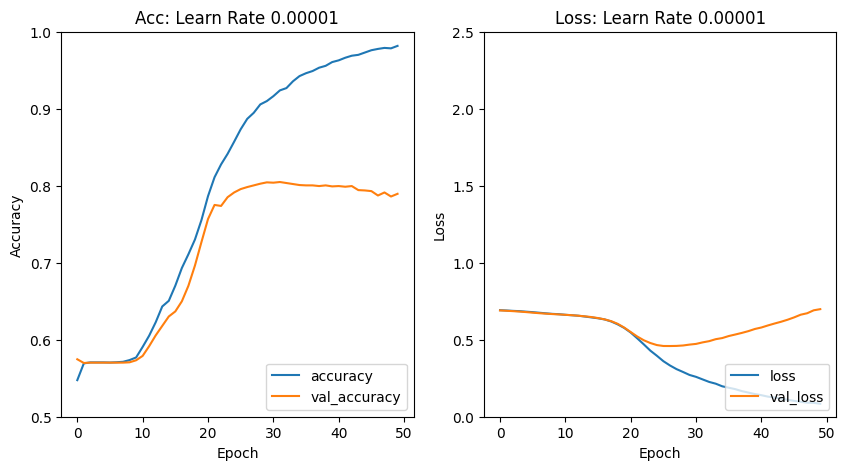

In [122]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(history3.history['accuracy'], label='accuracy')
ax1.plot(history3.history['val_accuracy'], label = 'val_accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_ylim([0.5, 1])
ax1.set_title('Acc: Learn Rate 0.00001')
ax1.legend(loc='lower right')

ax2.plot(history3.history['loss'], label='loss')
ax2.plot(history3.history['val_loss'], label = 'val_loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_ylim([0, 2.5])
ax2.set_title('Loss: Learn Rate 0.00001')
ax2.legend(loc='lower right')

The good news is that there's a much nicer looking curve, and it doesn't overfit too quickly. The bad news is that the accuracy is still maxing out at 0.8, so the actual accuracy hasn't really improved by lowering the learning rate. This likely means there's either some other other hyperparamter I need to tune, there might be issues with how I preprocessed the data, or the model itself needs changes.